# PPE 31 - KYTH : Know Your worTH

Authors : Hippolyte COUSIN - Sosthene DE LAMOTTE - Oscar MARZE - Paul SENARD - Camil TIRES - Tiago TEIXEIRA LOPES


Nous avons étudié le fonctionnement des techniques récentes notamment celles proposées dans un article de recherche sur la  [Deep Distribution Regression](https://arxiv.org/pdf/1903.06023.pdf). Il nous a servi de guide pour nos expérimentations tout au long du projet.  Trois chercheurs Rui Li , Howard D. Bondell and Brian J. Reich y présentent leur solution pour le concours Global Energy Forecasting Competition  de 2014 (cette publication date du 14 mars 2019). Ils présentent aussi une solution afin d’obtenir une distribution conditionnelle complète qui contient des informations pouvant être cruciales. 



## Installation des Bibliothèques

In [1]:
pip intall numpy 

ERROR: unknown command "intall" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


## Importation des Bibliothèques

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from collections import Counter

import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout

# 1. Visualisation des données

Les données avec lesquelles nous travaillons sont issues de la compétition Global Energy Forecasting 2014, dont l'un des thèmes était la production d'énergie solaire, à partir de données de trois fermes solaires en Australie. 

Nous avons utilisé exclusivement les données d'une ferme, située dans la 'zone 1'. 

Cette ferme renvoyait chaque jour les valeurs horaires pour 12 variables, que nous avons choisi de toutes utiliser pour entraîner notre modèle.
En voici la liste :

* VAR78 : Teneur en eau dans les nuages en kilogramme par m2
* VAR79 : Teneur en eau dans les nuages en kilogramme par m2
* VAR134 : Pression en surface en Pascal
* VAR157 : Taux d'humidité relatif à 1000 millibar en %
* VAR164 : Couverture nuageuse totale
* VAR165 : Vitesse verticale du vent en mètre par seconde
* VAR166 : Vitesse horizontale du vent en mètre par seconde
* VAR167 : Température à 2 mètres de la surface en Kelvin
* VAR169 : Rayonnement solaire de surface en Joule par m2
* VAR175 : Rayonnement thermique en surface en Joule par m2
* VAR178 : Rayonnement solaire net en Joule par m2
* VAR228 : Précipitation totale en mètre

In [7]:
df = pd.read_csv("predictors15.csv")

In [8]:
df.info()
print(100*'-')
print(df.describe())
print(100*'-')
print("shape : ", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59112 entries, 0 to 59111
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ZONEID     59112 non-null  int64  
 1   TIMESTAMP  59112 non-null  object 
 2   VAR78      59112 non-null  float64
 3   VAR79      59112 non-null  float64
 4   VAR134     59112 non-null  float64
 5   VAR157     59112 non-null  float64
 6   VAR164     59112 non-null  float64
 7   VAR165     59112 non-null  float64
 8   VAR166     59112 non-null  float64
 9   VAR167     59112 non-null  float64
 10  VAR169     59112 non-null  float64
 11  VAR175     59112 non-null  float64
 12  VAR178     59112 non-null  float64
 13  VAR228     59112 non-null  float64
 14  POWER      59112 non-null  float64
dtypes: float64(13), int64(1), object(1)
memory usage: 6.8+ MB
----------------------------------------------------------------------------------------------------
             ZONEID         VAR78         VAR79

# 2. Data processing

In [9]:
df = df[df["POWER"] <= 1]

### A. Transformation de la date

On effectue une transformation de cosinus et sinus sur la date à l'aide de la fonction suivante afin de les rendre cycliques, car la puissance solaire dépend fortement des saisons.

In [10]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [11]:
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df["TIMESTAMP_year"] = df["TIMESTAMP"].dt.year

df['month'] = df["TIMESTAMP"].dt.month
df = encode(df, 'month', 12)

df['day'] = df["TIMESTAMP"].dt.day
df = encode(df, 'day', 365)

df['hour'] = df["TIMESTAMP"].dt.hour
df = encode(df, 'hour', 23.0)

#### Avant la transformation : 

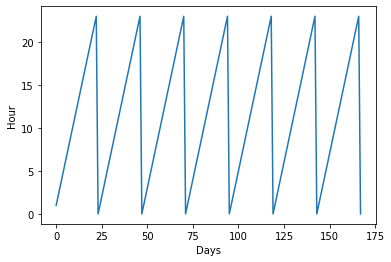

In [12]:
tmp = df[0:168]
tmp['hour'].plot()
plt.ylabel("Hour")
plt.xlabel("Days")
plt.show()

#### Après la transformation : 

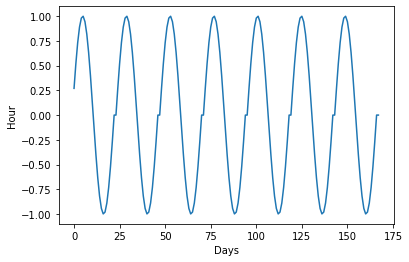

In [13]:
tmp['hour_sin'].plot()
plt.ylabel("Hour")
plt.xlabel("Days")
plt.show()

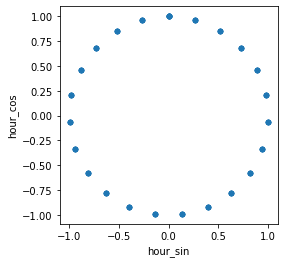

In [14]:
ex = tmp.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')

### B. Visualisation de l'allure de notre cible

On visualise l'évolution de l'énergie solaire pendant 4 jours du mois de Mars 2014.

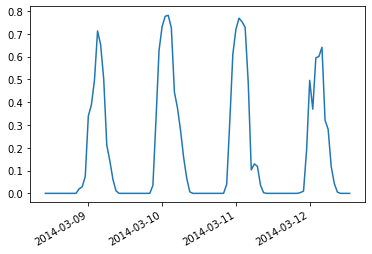

In [15]:
march = df.loc[df['TIMESTAMP_year'] == 2014]
march = march.loc[march['month'] == 3]
march = march.loc[march['ZONEID'] == 1][178:278]

time_march = march["TIMESTAMP"]
power_march = march["POWER"]

fig, _ = plt.subplots()
plt.plot(time_march,power_march)
plt.gca().xaxis.set_major_locator(mdate.DayLocator())
fig.autofmt_xdate()
plt.show()

### C. Selection de données

On sélectionne dans notre large jeu de données l'année 2013 ainsi que les données concernant la ferme 1. Cette première sélection va correspondre à notre jeu d'entraînement, puis on va établir notre jeu de test sur le mois de Janvier 2014. De plus on mélange notre dataset afin de ne pas biaiser nos résultats.

In [16]:
df_2013 = df.loc[df['TIMESTAMP_year'] == 2013]
df_2013_z1 = df_2013.loc[df_2013['ZONEID'] == 1]
df_2013_z1_shuffled = df_2013_z1.sample(frac=1)

In [17]:
df_2013_z1.shape

(8760, 25)

In [18]:
df_test = df.loc[df['TIMESTAMP_year'] == 2014]
df_test = df_test.loc[df_test["ZONEID"] == 1][:744]
df_test_shuffled = df_test.sample(frac=1)

In [19]:
df_2013_z1_shuffled.head()

,ZONEID,TIMESTAMP,VAR78,VAR79,VAR134,VAR157,VAR164,VAR165,VAR166,VAR167,...,TIMESTAMP_year,month,month_sin,month_cos,day,day_sin,day_cos,hour,hour_sin,hour_cos
10080,1,2013-05-26 01:00:00,0.000269,0.000000,95509.8750,73.670883,0.003357,0.880408,-1.313563,281.783691,...,2013,5,0.5,-8.660254e-01,26,0.432776,0.901502,1,0.269797,0.962917
9792,1,2013-05-14 01:00:00,0.000397,0.000000,94333.8750,59.226471,0.018616,3.695747,-1.695083,283.197754,...,2013,5,0.5,-8.660254e-01,14,0.238673,0.971100,1,0.269797,0.962917
13105,1,2013-09-29 02:00:00,0.000000,0.000115,94560.5625,41.457031,0.107376,4.276614,-1.685981,289.672363,...,2013,9,-1.0,-1.836970e-16,29,0.478734,0.877960,2,0.519584,0.854419
7044,1,2013-01-19 13:00:00,0.075386,0.000029,94675.1250,77.323059,0.832184,-4.048058,0.884130,288.686523,...,2013,1,0.5,8.660254e-01,19,0.321270,0.946988,13,-0.398401,-0.917211
8693,1,2013-03-29 06:00:00,0.000000,0.000000,94641.4375,33.168457,0.000000,0.127497,-0.781517,291.905762,...,2013,3,1.0,6.123234e-17,29,0.478734,0.877960,6,0.997669,-0.068242


### D. Undersampling

Dans un premier temps, on étudie la fréquence de valeurs nulles à chaque heure durant l'année 2013.

In [20]:
tmp = df_2013_z1_shuffled[df_2013_z1_shuffled["POWER"].eq(0)]

Class=13, n=365 (9.583%)
Class=18, n=365 (9.583%)
Class=14, n=365 (9.583%)
Class=20, n=167 (4.384%)
Class=17, n=365 (9.583%)
Class=16, n=365 (9.583%)
Class=10, n=266 (6.983%)
Class=12, n=365 (9.583%)
Class=11, n=365 (9.583%)
Class=15, n=365 (9.583%)
Class=19, n=274 (7.193%)
Class=9, n=161 (4.227%)
Class=21, n=18 (0.473%)
Class=8, n=2 (0.053%)
Class=3, n=1 (0.026%)


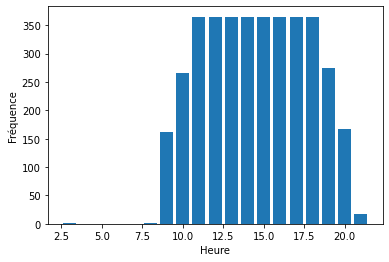

In [21]:
counter = Counter(tmp["hour"])
for k,v in counter.items():
    per = v / len(tmp["hour"]) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.xlabel("Heure")
plt.ylabel("Fréquence")
plt.show()

On remarque qu'à partir de 11h et ce jusqu'à 18h notre cible est nulle tout au long de l'année. On va donc procéder à un sous-échantillonage afin de réequilibrer notre dataset.

In [22]:
counter = Counter(tmp["hour"])
for k,v in counter.items():
    if(v > 100):
        df_tp = tmp[tmp["hour"].eq(k)].index
        drop_indices = np.random.choice(df_tp,v-100, replace=False )
        df_2013_z1_shuffled = df_2013_z1_shuffled.drop(drop_indices)

In [23]:
tmp = df_2013_z1_shuffled[df_2013_z1_shuffled["POWER"].eq(0)]

Class=13, n=100 (8.190%)
Class=20, n=100 (8.190%)
Class=17, n=100 (8.190%)
Class=16, n=100 (8.190%)
Class=10, n=100 (8.190%)
Class=12, n=100 (8.190%)
Class=18, n=100 (8.190%)
Class=11, n=100 (8.190%)
Class=14, n=100 (8.190%)
Class=19, n=100 (8.190%)
Class=21, n=18 (1.474%)
Class=9, n=100 (8.190%)
Class=15, n=100 (8.190%)
Class=8, n=2 (0.164%)
Class=3, n=1 (0.082%)


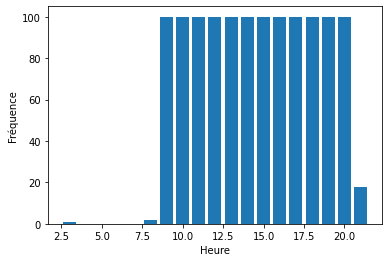

In [24]:
counter = Counter(tmp["hour"])
for k,v in counter.items():
    per = v / len(tmp["hour"]) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.xlabel("Heure")
plt.ylabel("Fréquence")
plt.show()

Pour réaliser ce sous-échantillonage, on réduit le nombre données des heures oû l'on obtient plus de 100 jours nulle sur l'année.

### E. Elimintation de features et visualisation du jeu d'entraînement et du jeu de test

In [25]:
col = ["ZONEID","TIMESTAMP", "TIMESTAMP_year", "month", "day"]

X_train = df_2013_z1_shuffled.drop("POWER", axis=1)
X_train = X_train.drop(col, axis=1)
y_train = df_2013_z1_shuffled["POWER"]

X_test = df_test_shuffled.drop("POWER", axis=1)
X_test = X_test.drop(col, axis=1)
y_test = df_test_shuffled["POWER"]

print("Train size : ", X_train.shape)
print("Train size : ", y_train.shape)
print("Test size : ", X_test.shape)
print("Test size : ", y_test.shape)

Train size :  (6172, 19)
Train size :  (6172,)
Test size :  (744, 19)
Test size :  (744,)


In [26]:
X_train.head()

,VAR78,VAR79,VAR134,VAR157,VAR164,VAR165,VAR166,VAR167,VAR169,VAR175,VAR178,VAR228,month_sin,month_cos,day_sin,day_cos,hour,hour_sin,hour_cos
10080,0.000269,0.000000,95509.8750,73.670883,0.003357,0.880408,-1.313563,281.783691,1506249.0,1.049106e+06,1708261.0,0.0,0.5,-8.660254e-01,0.432776,0.901502,1,0.269797,0.962917
9792,0.000397,0.000000,94333.8750,59.226471,0.018616,3.695747,-1.695083,283.197754,1867722.0,9.437136e+05,2021226.0,0.0,0.5,-8.660254e-01,0.238673,0.971100,1,0.269797,0.962917
13105,0.000000,0.000115,94560.5625,41.457031,0.107376,4.276614,-1.685981,289.672363,6290867.0,2.019752e+06,6572616.0,0.0,-1.0,-1.836970e-16,0.478734,0.877960,2,0.519584,0.854419
7044,0.075386,0.000029,94675.1250,77.323059,0.832184,-4.048058,0.884130,288.686523,15644498.0,1.736405e+07,20426496.0,0.0,0.5,8.660254e-01,0.321270,0.946988,13,-0.398401,-0.917211
8693,0.000000,0.000000,94641.4375,33.168457,0.000000,0.127497,-0.781517,291.905762,15782709.0,6.227145e+06,16785888.0,0.0,1.0,6.123234e-17,0.478734,0.877960,6,0.997669,-0.068242


In [27]:
X_test.head()

,VAR78,VAR79,VAR134,VAR157,VAR164,VAR165,VAR166,VAR167,VAR169,VAR175,VAR178,VAR228,month_sin,month_cos,day_sin,day_cos,hour,hour_sin,hour_cos
15543,0.004456,0.000269,95264.1875,82.798676,0.197327,-1.955809,0.981257,284.140625,23502768.0,18170784.0,26044848.0,0.000000,0.5,0.866025,0.137279,0.990532,16,-0.942261,-0.334880
15841,0.004791,0.000151,93889.0000,43.080002,0.285556,1.442891,-0.948500,298.718506,5457367.0,2874461.0,6589267.0,0.000000,0.5,0.866025,0.353676,0.935368,2,0.519584,0.854419
15396,0.135162,0.096794,93777.9375,44.131424,0.946505,3.286168,-2.018308,292.993652,15447972.0,17594112.0,20695024.0,0.000000,0.5,0.866025,0.034422,0.999407,13,-0.398401,-0.917211
15915,0.669870,0.236113,93955.3125,92.488327,1.000000,2.936502,-4.393728,291.027832,4291167.0,5518969.0,8345551.0,0.004534,0.5,0.866025,0.401488,0.915864,4,0.887885,0.460065
15620,0.000000,0.000000,94816.3750,65.258621,0.000000,-1.032138,1.028440,292.670166,18147920.0,27508528.0,23037472.0,0.000000,0.5,0.866025,0.188227,0.982126,21,-0.519584,0.854419


# 4. Modèles de Regression

### A. Régression Linéaire

Nous avons d'abord travaillé avec un modèle de Regression Linéaire sur notre jeu de 12 données. Il ne s'agit pas vraiment de précision, mais nous obtenons un score de prédicition de 75% par rapport à la valeur produite effective.

In [28]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test)

print("Train score : ", train_score)
print("Test score :", test_score)

Train score :  0.7222219789342638
Test score : 0.7604717960568754


### B. Random Forest Regressor

Nous avons ensuite travaillé avec un second algorithme, le Random Forest Regression. Un Random Forest est constitué d'un certain nombre n_estimators d'arbres décisionnels, dans notre cas 30. Chaque arbre dispose d'une vision partielle des données et à partir d'une étude des possibilités, établit une prédiction. Finalement, la valeur finale prédite est l'estimation majoritaire de tous les arbres.
Parmi les paramètres de ce modèle :

* random_state : la graine utilisée par le générateur de nombres aléatoires, pour que le résultat de l'algorithme soit le même à chaque fois
* max_depth : le nombre de variables que l'on va diviser (split) pour créer les branches de l'arbre
* min_samples_leaf : 
* min_samples_split : 
* n_estimators : le nombre d'arbres que l'on souhaite générer

Pour que cet algorithme soit le plus précis possible, il faut que les variables que l'on divise soient les plus optimales. Pour cela, on utilise l'algorithme de Grid Search qui va déterminer les paramètres idéaux.

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

params = {'min_samples_leaf':list(range(1,8,3)),'min_samples_split':list(range(2,11,2)),
          'n_estimators':list(range(20,41,10)), 'max_depth':[2,3]}

clf_rf2 = RandomForestRegressor(random_state=1)
clf_gs = GridSearchCV(clf_rf2, params,cv=5)
clf_gs.fit(X_train, y_train)
print("Best score : ", clf_gs.best_score_)
print("Best params :", clf_gs.best_params_)

Best score :  0.8221474088376193
Best params : {'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 40}


In [30]:

clf_r3 = RandomForestRegressor(random_state = 1, max_depth = 3, min_samples_leaf = 1, 
                               min_samples_split = 2, n_estimators = 30)
clf_r3.fit(X_train, y_train)
print(clf_r3.score(X_train, y_train))
print(clf_r3.score(X_test, y_test))

0.83195283668053
0.8690109229163321


#### Prédictions sur 4 jours du mois de Mars 2014

In [31]:
march = march.drop(col, axis=1)
march_pred = march.drop("POWER", axis=1)
power_march_pred_reg = reg.predict(march_pred)
power_march_pred_randomforest = clf_r3.predict(march_pred)

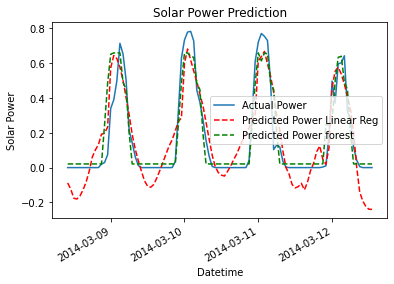

In [32]:
fig, _ = plt.subplots()
plt.plot(time_march,power_march, label="Actual Power")
plt.plot(time_march,power_march_pred_reg, "r--", label="Predicted Power Linear Reg")
plt.plot(time_march,power_march_pred_randomforest, "g--", label="Predicted Power forest")
plt.title("Solar Power Prediction")
plt.xlabel("Datetime")
plt.ylabel("Solar Power")
plt.gca().xaxis.set_major_locator(mdate.DayLocator())
plt.legend()
fig.autofmt_xdate()
plt.show()


### C. Random Forest Quantile Regressor

In [33]:
from skgarden import RandomForestQuantileRegressor

rfqr = RandomForestQuantileRegressor(
    random_state=0, min_samples_split=10, n_estimators=1000)

rfqr.fit(X_train, y_train)

/home/tiago/anaconda3/envs/ppe/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


RandomForestQuantileRegressor(bootstrap=True, criterion='mse', max_depth=None,
                              max_features='auto', max_leaf_nodes=None,
                              min_samples_leaf=1, min_samples_split=10,
                              min_weight_fraction_leaf=0.0, n_estimators=1000,
                              n_jobs=1, oob_score=False, random_state=0,
                              verbose=0, warm_start=False)

In [34]:
train_score = rfqr.score(X_train, y_train)
test_score = rfqr.score(X_test, y_test)

print("Train score : ", train_score)
print("Test score :", test_score)

Train score :  0.9735483389603301
Test score : 0.9564222482480492


#### Prédictions sur 4 jours du mois de Mars 2014

In [35]:
march_pred = march.drop("POWER", axis=1)
power_march_pred_quantrandomforest = rfqr.predict(march_pred)
power_march_pred_randomforest = clf_r3.predict(march_pred)

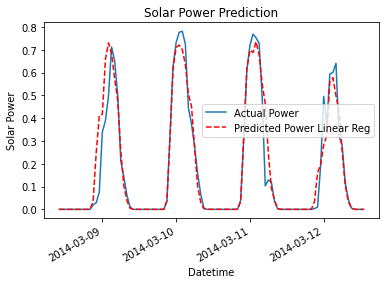

In [36]:
fig, _ = plt.subplots()
plt.plot(time_march,power_march, label="Actual Power")
plt.plot(time_march,power_march_pred_quantrandomforest, "r--", label="Predicted Power Linear Reg")
plt.gca().xaxis.set_major_locator(mdate.DayLocator())
plt.title("Solar Power Prediction")
plt.xlabel("Datetime")
plt.ylabel("Solar Power")
plt.legend()
fig.autofmt_xdate()
plt.show()

#### Validation croisée du Random Forest Quantile Regressor 

In [37]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rfqr, X, y, cv=5)

print (scores)
print ('scores mean =', scores.mean(), 'scores std =', scores.std())

[0.90684175 0.91654037 0.90322519 0.89087883 0.94195493]
scores mean = 0.9118882150131642 scores std = 0.01713218538535058


# 5. Transformation du problème

L’objectif était de transformer un algorithme de régression en un algorithme de classification multi-classes selon le modèle présenté dans le papier scientifique. Pour réaliser cette transformation, nous avons partitionné nos données afin d’obtenir **m** classes. 

Dans la fonction ci-dessous, on va utilisé un pas(step) afin de partitionné les données en  500 intervalles équivalents. 

In [39]:
m_cut_points = 500
def split_by_bins(m, df_po):
    step = 1/m
    bins = list(np.arange(0,df_po.max(),step))
    tmp = pd.cut(df_po,bins,include_lowest=True)
    categories = tmp.cat.categories
    tmp = tmp.cat.codes
    tmp = np.where(tmp==-1, m, tmp) 
    return tmp, categories
y_train, categ_train = split_by_bins(m_cut_points,df_2013_z1_shuffled["POWER"])
y_test, categ_test = split_by_bins(m_cut_points,df_test_shuffled["POWER"])

#### Visualisation des catégories

In [40]:
categ_train

IntervalIndex([(-0.001, 0.002], (0.002, 0.004], (0.004, 0.006], (0.006, 0.008], (0.008, 0.01] ... (0.898, 0.9], (0.9, 0.902], (0.902, 0.904], (0.904, 0.906], (0.906, 0.908]],
              closed='right',
              dtype='interval[float64]')

#### Visualisation de la répartition des données

Class=60, n=6 (0.097%)
Class=383, n=10 (0.162%)
Class=422, n=6 (0.097%)
Class=0, n=1674 (27.122%)
Class=132, n=10 (0.162%)
Class=315, n=10 (0.162%)
Class=114, n=11 (0.178%)
Class=323, n=11 (0.178%)
Class=307, n=11 (0.178%)
Class=71, n=10 (0.162%)
Class=12, n=38 (0.616%)
Class=61, n=19 (0.308%)
Class=213, n=6 (0.097%)
Class=301, n=7 (0.113%)
Class=251, n=4 (0.065%)
Class=289, n=11 (0.178%)
Class=9, n=53 (0.859%)
Class=72, n=10 (0.162%)
Class=397, n=6 (0.097%)
Class=217, n=4 (0.065%)
Class=1, n=110 (1.782%)
Class=414, n=7 (0.113%)
Class=2, n=64 (1.037%)
Class=360, n=11 (0.178%)
Class=373, n=4 (0.065%)
Class=260, n=4 (0.065%)
Class=91, n=14 (0.227%)
Class=359, n=15 (0.243%)
Class=37, n=19 (0.308%)
Class=262, n=9 (0.146%)
Class=70, n=13 (0.211%)
Class=130, n=9 (0.146%)
Class=186, n=11 (0.178%)
Class=6, n=47 (0.762%)
Class=264, n=9 (0.146%)
Class=112, n=11 (0.178%)
Class=349, n=8 (0.130%)
Class=238, n=2 (0.032%)
Class=5, n=38 (0.616%)
Class=255, n=9 (0.146%)
Class=269, n=8 (0.130%)
Class=35

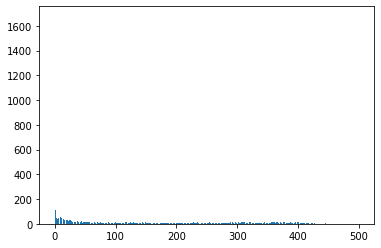

In [41]:
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

Malgrè notre sous-échantillonage, on remarque que la catégorie 0 correspondant à nos valeurs nulles **27%** du jeu de données.

# 6. Transformation de nos labels en catégories

Vecteur de classes convertit en matrice (entiers de 0 à num_classes). 

In [42]:
y_train_cat = keras.utils.to_categorical(y_train, num_classes=m_cut_points+1)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=m_cut_points+1)
print("Train size X : ", X_train.shape)
print("Train size y : ", y_train.shape)
print("Test size X : ", X_test.shape)
print("Test size y : ", y_test.shape)

Train size X :  (6172, 19)
Train size y :  (6172,)
Test size X :  (744, 19)
Test size y :  (744,)


In [43]:
y_train[:5]

array([ 60, 383, 422,   0, 132], dtype=int16)

In [44]:
y_train_cat[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# 7. Modèles de classification

### A. Régression Logistique

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


regl = LogisticRegression(C=50. / X_train.shape[0], penalty='l1', solver='saga', tol=0.1, multi_class='multinomial')

regl.fit(X_train, y_train)
train_score = regl.score(X_train, y_train)
test_score = regl.score(X_test, y_test)

print("Train score : ", train_score)
print("Test score :", test_score)

Train score :  0.2712248865845755
Test score : 0.396505376344086


### B. K-nearest neighbors

In [48]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_train)

In [49]:
train_score = knn_classifier.score(X_train, y_train)
test_score = knn_classifier.score(X_test, y_test)

print("Train score : ", train_score)
print("Test score :", test_score)

Train score :  0.411049902786779
Test score : 0.3951612903225806


In [67]:
march_pred = march.drop("POWER", axis=1)
power_march_pred_regl = regl.predict(march_pred)
power_march_pred_randomforest = clf_r3.predict(march_pred)
power_march_pred_knn = knn_classifier.predict(march_pred)/m_cut_points

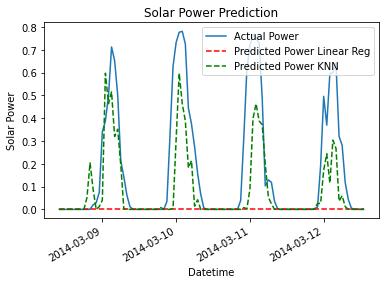

In [68]:
fig, _ = plt.subplots()
plt.plot(time_march,power_march, label="Actual Power")
plt.plot(time_march,power_march_pred_regl, "r--", label="Predicted Power Linear Reg")
plt.plot(time_march,power_march_pred_knn, "g--", label="Predicted Power KNN")
plt.gca().xaxis.set_major_locator(mdate.DayLocator())
plt.title("Solar Power Prediction")
plt.xlabel("Datetime")
plt.ylabel("Solar Power")
plt.legend()
fig.autofmt_xdate()
plt.show()

# 8. Graphique

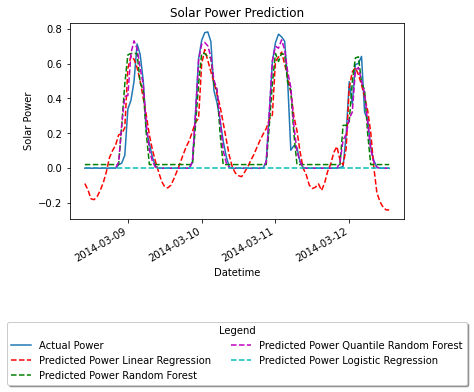

In [50]:
fig, _ = plt.subplots()
plt.plot(time_march,power_march, label="Actual Power")
plt.plot(time_march,power_march_pred_reg, "r--", label="Predicted Power Linear Regression")
plt.plot(time_march,power_march_pred_randomforest, "g--", label="Predicted Power Random Forest")
plt.plot(time_march,power_march_pred_quantrandomforest, "m--", label="Predicted Power Quantile Random Forest")
plt.plot(time_march,power_march_pred_regl, "c--", label="Predicted Power Logistic Regression")
plt.title("Solar Power Prediction")
plt.xlabel("Datetime")
plt.ylabel("Solar Power")
plt.gca().xaxis.set_major_locator(mdate.DayLocator())
plt.legend(title='Legend', bbox_to_anchor=(0.5, -0.5),fancybox=True, shadow=True, ncol=2, loc='upper center')
fig.autofmt_xdate()
plt.show()

# 9. Modèle de Deep Learning

### A. Architecture du réseau de neurones

In [51]:
model = Sequential()
model.add(keras.layers.Dense(100, activation="elu",input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(100, activation="elu", name="layer3"))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(100, activation="elu", name="layer4"))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(m_cut_points+1, activation='softmax', name="output_layer"))

In [52]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2000      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
layer3 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
layer4 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
output_layer (Dense)         (None, 501)               5

### B. Entrainement du modèle

In [54]:
hist = model.fit(X_train, y_train_cat, batch_size = 4,verbose=2, validation_split=0.2, epochs=10)

Epoch 1/10
1235/1235 - 4s - loss: 8269.4570 - accuracy: 0.1351 - val_loss: 0.0123 - val_accuracy: 0.2648
Epoch 2/10
1235/1235 - 2s - loss: 21.6574 - accuracy: 0.2714 - val_loss: 0.0119 - val_accuracy: 0.2648
Epoch 3/10
1235/1235 - 2s - loss: 41.2368 - accuracy: 0.2698 - val_loss: 0.0119 - val_accuracy: 0.2648
Epoch 4/10
1235/1235 - 1s - loss: 63.5042 - accuracy: 0.2696 - val_loss: 0.0129 - val_accuracy: 0.2648
Epoch 5/10
1235/1235 - 1s - loss: 59.3148 - accuracy: 0.2690 - val_loss: 0.0134 - val_accuracy: 0.2648
Epoch 6/10
1235/1235 - 1s - loss: 40.1947 - accuracy: 0.2710 - val_loss: 0.0136 - val_accuracy: 0.2648
Epoch 7/10
1235/1235 - 1s - loss: 30.4830 - accuracy: 0.2706 - val_loss: 0.0123 - val_accuracy: 0.2648
Epoch 8/10
1235/1235 - 2s - loss: 28.0074 - accuracy: 0.2704 - val_loss: 0.0123 - val_accuracy: 0.2648
Epoch 9/10
1235/1235 - 1s - loss: 27.7906 - accuracy: 0.2708 - val_loss: 0.0123 - val_accuracy: 0.2648
Epoch 10/10
1235/1235 - 1s - loss: 33.4628 - accuracy: 0.2694 - val_los

### C. Visualisaton de la Loss

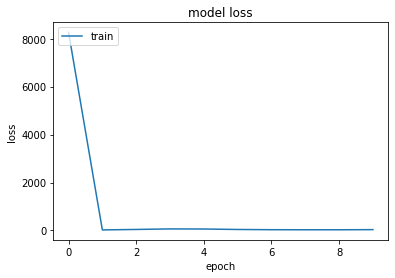

In [55]:
plt.plot(hist.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [56]:
predictions = model.predict(X_train)
print(predictions[150:160])

[[4.9001470e-01 2.5112037e-02 6.0564443e-03 ... 5.4911000e-04
  4.8783509e-04 5.4167438e-04]
 [4.9001470e-01 2.5112037e-02 6.0564443e-03 ... 5.4911000e-04
  4.8783509e-04 5.4167438e-04]
 [4.9001470e-01 2.5112037e-02 6.0564443e-03 ... 5.4911000e-04
  4.8783509e-04 5.4167438e-04]
 ...
 [4.9001470e-01 2.5112037e-02 6.0564443e-03 ... 5.4911000e-04
  4.8783509e-04 5.4167438e-04]
 [4.9001470e-01 2.5112046e-02 6.0564391e-03 ... 5.4911000e-04
  4.8783509e-04 5.4167386e-04]
 [4.9001470e-01 2.5112046e-02 6.0564391e-03 ... 5.4911000e-04
  4.8783503e-04 5.4167386e-04]]
